# 경로지정
136까지 완료

In [21]:
import pandas as pd
from pathlib import Path
import shutil  # 파일 복사용

# -------------------------------------------------------
# 경로 설정
# -------------------------------------------------------
CSV_PATH = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/ASAN_01_Repeatition_Counter/data/metadata_backup.csv")

# 확인할 행 번호
TARGET_ROW = 1009

# -------------------------------------------------------
# CSV 로드 및 행 접근
# -------------------------------------------------------
meta = pd.read_csv(CSV_PATH)

# -------------------------------------------------------
# 개별 경로 생성
# -------------------------------------------------------
FRAME_DIR = Path(str(meta.loc[TARGET_ROW]['frame_path']))
KEYPOINTS_DIR = Path(str(meta.loc[TARGET_ROW]['keypoints_path']))
INTERP_DIR = Path(str(meta.loc[TARGET_ROW]['interp_json_path']))
VIDEO_DIR =  Path(str(meta.loc[TARGET_ROW]['mp4_path']))

# -------------------------------------------------------
# 존재 여부 확인 및 폴더 생성
# -------------------------------------------------------
for p in [FRAME_DIR, KEYPOINTS_DIR, INTERP_DIR, VIDEO_DIR]:
    if not p.exists():
        if p == INTERP_DIR:
            p.mkdir(parents=True, exist_ok=True)
            print(f"📁 생성 완료: {p}")
        else:
            print(f"❌ 없음: {p}")
    else:
        print(f"✅ 존재: {p}")

    
# -------------------------------------------------------
# 현재 처리 대상 이름 변수 분리
# -------------------------------------------------------
parent_name = FRAME_DIR.parent.name                # 상위 폴더명 (예: N01_Ward)
current_name = FRAME_DIR.name                      # 현재 폴더명 (예: lateral__overhead_triceps_extension)
target_name = f"{parent_name}/{current_name}"      # 결합된 이름 생성

# -------------------------------------------------------
# 정보 출력
# -------------------------------------------------------
print(f"\nis_train = {meta.loc[TARGET_ROW]['is_train']}")       # 학습 데이터 여부 출력
print(f"is_train = {meta.loc[TARGET_ROW]['is_val']}")       # 학습 데이터 여부 출력

print(f"\n🎯 현재 처리 대상: {target_name}")                      # 상위폴더/하위폴더 형태로 출력

✅ 존재: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/1_FRAME/Won_Kim_research_at_Bosanjin/M01_VISIT12
✅ 존재: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/2_KEYPOINTS/Won_Kim_research_at_Bosanjin/M01_VISIT12
✅ 존재: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/4_INTERP_DATA/Won_Kim_research_at_Bosanjin/M01_VISIT12
✅ 존재: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/3_MP4/Won_Kim_research_at_Bosanjin/M01_VISIT12.mp4

is_train = False
is_train = False

🎯 현재 처리 대상: Won_Kim_research_at_Bosanjin/M01_VISIT12


# JSON 복사

In [22]:
from tqdm import tqdm
import shutil

# -------------------------------------------------------
# 🔁 keypoints → interp_json 복사 (with tqdm)
# -------------------------------------------------------
if KEYPOINTS_DIR.exists():
    json_files = list(KEYPOINTS_DIR.glob("*.json"))
    for json_file in tqdm(json_files, desc="📦 JSON 복사 중", ncols=80):
        shutil.copy(json_file, INTERP_DIR / json_file.name)  # JSON 복사
    print(f"✅ {len(json_files)}개 JSON 복사 완료 → {INTERP_DIR}")
else:
    print("⚠️ KEYPOINTS_DIR가 존재하지 않아 복사 스킵됨")


📦 JSON 복사 중: 100%|███████████████████| 45614/45614 [02:12<00:00, 344.69it/s]

✅ 45614개 JSON 복사 완료 → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/4_INTERP_DATA/Won_Kim_research_at_Bosanjin/M01_VISIT12


# 필수 함수

## frame overlay 시각화 함수

In [23]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------------------------------------
# (1) Frame overlay 시각화 함수 (2열 배치, 5~16만 표시)
# -------------------------------------------------------
def visualize_frame_overlay(frame_dir: Path, json_dir: Path, frame_idx: int, window: int = 5):
    """
    frame_idx 기준 ±window 프레임의 skeleton을 시각화 (2열 다중행)
    - COCO 17 중 5~16만 표시
    """
    start_idx = max(0, frame_idx - window)
    end_idx = frame_idx + window + 1
    frame_indices = list(range(start_idx, end_idx))
    n_frames = len(frame_indices)

    # COCO 17개 중 5~16만 남기기
    links = [
        (15, 13), (13, 11),
        (16, 14), (14, 12),
        (11, 12),
        (5, 11), (6, 12),
        (5, 6),
        (5, 7), (7, 9),
        (6, 8), (8, 10)
    ]
    left_points = [5, 7, 9, 11, 13, 15]
    right_points = [6, 8, 10, 12, 14, 16]

    # -------------------------------------------------------
    # Subplot 설정 (2열 자동 행 계산)
    # -------------------------------------------------------
    n_cols = 2
    n_rows = int(np.ceil(n_frames / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3.5 * n_rows))
    axes = np.array(axes).reshape(-1)  # 1D로 평탄화

    for ax, idx in zip(axes, frame_indices):
        frame_path = frame_dir / f"{idx:06d}.jpg"
        json_path = json_dir / f"{idx:06d}.json"

        if not frame_path.exists() or not json_path.exists():
            ax.axis("off")
            continue

        frame = cv2.imread(str(frame_path))
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            ax.axis("off")
            continue

        for person in data["instance_info"]:
            kpts = np.array(person["keypoints"])
            for a, b in links:
                if a >= len(kpts) or b >= len(kpts):
                    continue
                pt1, pt2 = tuple(map(int, kpts[a])), tuple(map(int, kpts[b]))
                cv2.line(frame, pt1, pt2, (80, 80, 80), 2)

            for kp_idx, (x, y) in enumerate(kpts):
                if kp_idx < 5 or kp_idx > 16:
                    continue
                if kp_idx in left_points:
                    color = (255, 0, 0)
                elif kp_idx in right_points:
                    color = (0, 0, 255)
                else:
                    color = (0, 255, 0)
                cv2.circle(frame, (int(x), int(y)), 4, color, -1)

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        ax.imshow(frame_rgb)
        ax.set_title(f"Frame {idx:06d}", fontsize=10)
        ax.axis("off")

    # 남는 subplot 숨김
    for ax in axes[n_frames:]:
        ax.axis("off")

    plt.suptitle(f"Skeletons around Frame {frame_idx:06d} (±{window})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [24]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------------------------------------
# (2) 단일 프레임 skeleton 시각화 함수
# -------------------------------------------------------
def visualize_single_frame(frame_dir: Path, json_dir: Path, frame_idx: int, show_kp_idx: bool = True):
    """
    지정한 단일 프레임을 크게 시각화 (5~16 keypoints만 표시)
    - show_kp_idx=True → 각 keypoint 번호도 함께 출력
    """
    frame_path = frame_dir / f"{frame_idx:06d}.jpg"
    json_path = json_dir / f"{frame_idx:06d}.json"

    if not frame_path.exists() or not json_path.exists():
        print(f"❌ Frame {frame_idx:06d}: frame 또는 JSON 없음")
        return

    # ---------------------------------------------------
    # 기본 skeleton 구조 (5~16만)
    # ---------------------------------------------------
    links = [
        (15, 13), (13, 11),
        (16, 14), (14, 12),
        (11, 12),
        (5, 11), (6, 12),
        (5, 6),
        (5, 7), (7, 9),
        (6, 8), (8, 10)
    ]
    left_points = [5, 7, 9, 11, 13, 15]
    right_points = [6, 8, 10, 12, 14, 16]

    # ---------------------------------------------------
    # 데이터 로드
    # ---------------------------------------------------
    frame = cv2.imread(str(frame_path))
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    if "instance_info" not in data or not data["instance_info"]:
        print(f"⚠️ Frame {frame_idx:06d}: instance_info 없음")
        return

    # ---------------------------------------------------
    # skeleton overlay
    # ---------------------------------------------------
    for person in data["instance_info"]:
        kpts = np.array(person["keypoints"])
        for a, b in links:
            if a >= len(kpts) or b >= len(kpts):
                continue
            pt1, pt2 = tuple(map(int, kpts[a])), tuple(map(int, kpts[b]))
            cv2.line(frame, pt1, pt2, (80, 80, 80), 3)

        for kp_idx, (x, y) in enumerate(kpts):
            if kp_idx < 5 or kp_idx > 16:
                continue
            if kp_idx in left_points:
                color = (255, 0, 0)
            elif kp_idx in right_points:
                color = (0, 0, 255)
            else:
                color = (0, 255, 0)
            cv2.circle(frame, (int(x), int(y)), 6, color, -1)

            if show_kp_idx:
                cv2.putText(frame, str(kp_idx), (int(x)+5, int(y)-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

    # ---------------------------------------------------
    # 시각화
    # ---------------------------------------------------
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(frame_rgb)
    plt.axis("off")
    plt.title(f"Frame {frame_idx:06d}", fontsize=16)
    plt.show()


## 영상 생성 함수

In [6]:
import sys
sys.path.append("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/ASAN_01_Repeatition_Counter")

from functions.render_skeleton_video import render_skeleton_video

## IQR 시각화 함수

In [7]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

# -------------------------------------------------------
# (함수) keypoints 전체 IQR + Boxplot 4컬럼 시각화 (Outlier 표시 포함)
# -------------------------------------------------------
def plot_keypoint_iqr_overview(json_dir: Path, keypoint_range=(5, 17), whisker: float = 1.5):
    """
    keypoint별 X/Y 좌표 시계열 + Boxplot을 한 행에 표시하며,
    IQR 기반 이상치(Outlier)를 점으로 표시.

    Args:
        json_dir (Path): keypoints JSON 폴더
        keypoint_range (tuple): 분석할 keypoints 범위 (기본 5~16)
        whisker (float): IQR 배수 (1.5 → 일반적인 Tukey 기준)
    """
    json_files = sorted(json_dir.glob("*.json"))
    print(f"[INFO] 총 {len(json_files)}개 JSON 로드 중...")

    all_kpts = []
    for jfile in tqdm(json_files):
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            all_kpts.append(np.full((17, 2), np.nan))
            continue
        kpts = np.array(data["instance_info"][0]["keypoints"])  # (17, 2)
        all_kpts.append(kpts)

    all_kpts = np.stack(all_kpts)  # (frame, kp, 2)
    frames = np.arange(len(all_kpts))

    # -------------------------------------------------------
    # IQR 계산 함수
    # -------------------------------------------------------
    def compute_iqr(values, whisker):
        q1 = np.percentile(values, 25)
        q3 = np.percentile(values, 75)
        iqr = q3 - q1
        lower = q1 - whisker * iqr
        upper = q3 + whisker * iqr
        return q1, q3, iqr, lower, upper

    # -------------------------------------------------------
    # 시각화 준비
    # -------------------------------------------------------
    kp_indices = list(range(*keypoint_range))
    n_kp = len(kp_indices)
    fig, axes = plt.subplots(n_kp, 4, figsize=(18, 2.8 * n_kp))

    if n_kp == 1:
        axes = axes.reshape(1, 4)

    for row_idx, kp_idx in enumerate(kp_indices):
        xs = all_kpts[:, kp_idx, 0]
        ys = all_kpts[:, kp_idx, 1]

        valid_x = xs[~np.isnan(xs)]
        valid_y = ys[~np.isnan(ys)]
        if len(valid_x) < 5:
            continue

        # IQR 계산
        q1x, q3x, iqrx, lower_x, upper_x = compute_iqr(valid_x, whisker)
        q1y, q3y, iqry, lower_y, upper_y = compute_iqr(valid_y, whisker)

        # 이상치 마스크
        outlier_x_mask = (xs < lower_x) | (xs > upper_x)
        outlier_y_mask = (ys < lower_y) | (ys > upper_y)

        # ------------------------------
        # (1) X 시계열 + outlier
        # ------------------------------
        ax = axes[row_idx, 0]
        ax.plot(frames, xs, color="dodgerblue", linewidth=1)
        ax.axhline(lower_x, color="red", linestyle="--", alpha=0.5)
        ax.axhline(upper_x, color="red", linestyle="--", alpha=0.5)
        ax.scatter(frames[outlier_x_mask], xs[outlier_x_mask],
                   color="crimson", s=15, zorder=3, label="Outlier")
        ax.set_title(f"kpt{kp_idx} X", fontsize=9)
        ax.grid(True, linestyle="--", alpha=0.4)

        # ------------------------------
        # (2) Y 시계열 + outlier
        # ------------------------------
        ax = axes[row_idx, 1]
        ax.plot(frames, ys, color="darkorange", linewidth=1)
        ax.axhline(lower_y, color="red", linestyle="--", alpha=0.5)
        ax.axhline(upper_y, color="red", linestyle="--", alpha=0.5)
        ax.scatter(frames[outlier_y_mask], ys[outlier_y_mask],
                   color="purple", s=15, zorder=3, label="Outlier")
        ax.set_title(f"kpt{kp_idx} Y", fontsize=9)
        ax.grid(True, linestyle="--", alpha=0.4)

        # ------------------------------
        # (3) X Boxplot (Outlier 자동 표시)
        # ------------------------------
        ax = axes[row_idx, 2]
        ax.boxplot(xs[~np.isnan(xs)],
                patch_artist=True,
                whis=whisker,                     # ✅ 여기 추가!
                boxprops=dict(facecolor="lightblue", color="navy"),
                medianprops=dict(color="red"),
                flierprops=dict(marker='o', markerfacecolor='crimson',
                                markersize=4, linestyle='none'))

        ax.set_title("X Box", fontsize=9)
        ax.set_xticks([])

        # ------------------------------
        # (4) Y Boxplot (Outlier 자동 표시)
        # ------------------------------
        ax = axes[row_idx, 3]
        ax.boxplot(ys[~np.isnan(ys)],
                patch_artist=True,
                whis=whisker,                     # ✅ 동일하게 반영
                boxprops=dict(facecolor="lightcoral", color="maroon"),
                medianprops=dict(color="black"),
                flierprops=dict(marker='o', markerfacecolor='purple',
                                markersize=4, linestyle='none'))

        ax.set_title("Y Box", fontsize=9)
        ax.set_xticks([])

    plt.suptitle(f"IQR Overview per Keypoint (whisker={whisker})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


In [8]:
import json
import numpy as np
from pathlib import Path
from tqdm import tqdm

# -------------------------------------------------------
# (함수) IQR 기반 Outlier 선형보간 (연속 구간 + X/Y 선택)
# -------------------------------------------------------
def interpolate_outliers(json_dir: Path,
                         target_kps=[14, 16],
                         whisker=1.5,
                         axis='both',
                         save_dir: Path = None):
    """
    지정된 keypoints에서 IQR 기반 이상치를 선형 보간으로 수정
    (연속 outlier 구간도 자연스럽게 처리)
    
    Args:
        json_dir (Path): keypoints JSON 폴더
        target_kps (list): 보간 대상 keypoint index
        whisker (float): IQR 배수
        axis (str): 'x', 'y', 'both' 중 선택
        save_dir (Path): 결과 저장 경로 (None → 원본 덮어쓰기)
    """
    json_files = sorted(json_dir.glob("*.json"))
    print(f"[INFO] 총 {len(json_files)}개 JSON 로드 중...")

    # -------------------------------------------------------
    # 1️⃣ 전체 keypoints 로드
    # -------------------------------------------------------
    all_kpts = []
    for jfile in json_files:
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            all_kpts.append(np.full((17, 2), np.nan))
            continue
        kpts = np.array(data["instance_info"][0]["keypoints"], dtype=float)
        if kpts.ndim != 2 or kpts.shape[1] != 2:
            kpts = np.full((17, 2), np.nan)
        all_kpts.append(kpts)
    all_kpts = np.stack(all_kpts)
    frames = np.arange(len(all_kpts))

    # -------------------------------------------------------
    # 2️⃣ IQR 계산 함수
    # -------------------------------------------------------
    def compute_iqr(values, whisker):
        q1 = np.percentile(values, 25)
        q3 = np.percentile(values, 75)
        iqr = q3 - q1
        lower = q1 - whisker * iqr
        upper = q3 + whisker * iqr
        return lower, upper

    # -------------------------------------------------------
    # 3️⃣ 연속 outlier 구간을 묶어서 보간
    # -------------------------------------------------------
    for kp_idx in target_kps:
        xs = all_kpts[:, kp_idx, 0]
        ys = all_kpts[:, kp_idx, 1]

        # NaN 제거 후 IQR 계산
        valid_x = xs[~np.isnan(xs)]
        valid_y = ys[~np.isnan(ys)]
        if len(valid_x) < 5 or len(valid_y) < 5:
            print(f"[WARN] kpt{kp_idx}: 데이터 부족 → skip")
            continue

        # 선택된 축에 따라 outlier 계산
        lower_x, upper_x = compute_iqr(valid_x, whisker)
        lower_y, upper_y = compute_iqr(valid_y, whisker)

        outlier_mask_x = (xs < lower_x) | (xs > upper_x)
        outlier_mask_y = (ys < lower_y) | (ys > upper_y)

        if axis == 'x':
            outlier_mask = outlier_mask_x
        elif axis == 'y':
            outlier_mask = outlier_mask_y
        else:  # both
            outlier_mask = outlier_mask_x | outlier_mask_y

        outlier_indices = np.where(outlier_mask)[0]

        if len(outlier_indices) == 0:
            print(f"[INFO] kpt{kp_idx}: Outlier 없음 ✅")
            continue

        print(f"[INFO] kpt{kp_idx}: {len(outlier_indices)}개 Outlier → {axis}-축 기준 연속 구간 보간 중...")

        # 연속 구간 묶기
        groups = []
        current = [outlier_indices[0]]
        for f in outlier_indices[1:]:
            if f == current[-1] + 1:
                current.append(f)
            else:
                groups.append(current)
                current = [f]
        groups.append(current)

        # 각 그룹별 보간 수행
        for g in groups:
            left = g[0] - 1
            right = g[-1] + 1
            if left < 0 or right >= len(xs):
                continue
            if np.isnan(xs[left]) or np.isnan(xs[right]) or np.isnan(ys[left]) or np.isnan(ys[right]):
                continue

            num_points = len(g) + 2
            if axis in ['x', 'both']:
                interp_x = np.linspace(xs[left], xs[right], num_points)[1:-1]
                for i, idx in enumerate(g):
                    all_kpts[idx, kp_idx, 0] = interp_x[i]

            if axis in ['y', 'both']:
                interp_y = np.linspace(ys[left], ys[right], num_points)[1:-1]
                for i, idx in enumerate(g):
                    all_kpts[idx, kp_idx, 1] = interp_y[i]

        print(f"    → 보간 완료 구간: {[ (g[0], g[-1]) for g in groups ]}")

    # -------------------------------------------------------
    # 4️⃣ 보간 후 저장
    # -------------------------------------------------------
    if save_dir is None:
        save_dir = json_dir
    else:
        save_dir.mkdir(parents=True, exist_ok=True)

    for i, jfile in enumerate(tqdm(json_files, desc="Saving interpolated JSON")):
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            continue
        data["instance_info"][0]["keypoints"] = all_kpts[i].tolist()

        out_path = save_dir / jfile.name
        with open(out_path, "w", encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False, indent=2)

    print(f"✅ Outlier 보간 완료 ({axis}-축, keypoints={target_kps}, whisker={whisker}) → {save_dir}")


## smoothing 함수

In [9]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d

def smooth_keypoints(json_dir: Path,
                     target_kps: list,
                     window: int = 5,
                     method: str = "moving",
                     save_dir: Path = None):
    json_files = sorted(json_dir.glob("*.json"))
    print(f"[INFO] 총 {len(json_files)}개 JSON 로드 → smoothing keypoints: {target_kps}")

    if save_dir is None:
        save_dir = json_dir
    else:
        save_dir.mkdir(parents=True, exist_ok=True)

    all_kpts = []
    for jfile in json_files:
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            all_kpts.append(np.full((17, 2), np.nan))
            continue
        kpts = np.array(data["instance_info"][0]["keypoints"])
        all_kpts.append(kpts)
    all_kpts = np.stack(all_kpts)

    for kp_idx in target_kps:
        x = all_kpts[:, kp_idx, 0]
        y = all_kpts[:, kp_idx, 1]

        if method == "moving":
            # ✅ Pandas rolling 평균 사용 (경계 안전)
            x = pd.Series(x).rolling(window, center=True, min_periods=1).mean().to_numpy()
            y = pd.Series(y).rolling(window, center=True, min_periods=1).mean().to_numpy()
        elif method == "gaussian":
            x = gaussian_filter1d(x, sigma=window / 2)
            y = gaussian_filter1d(y, sigma=window / 2)
        else:
            raise ValueError("❌ method는 'moving' 또는 'gaussian'만 지원합니다.")

        all_kpts[:, kp_idx, 0] = x
        all_kpts[:, kp_idx, 1] = y

    for i, jfile in enumerate(tqdm(json_files, desc="Saving smoothed JSON")):
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            continue
        data["instance_info"][0]["keypoints"] = all_kpts[i].tolist()

        out_path = save_dir / jfile.name
        with open(out_path, "w", encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False, indent=2)

    print(f"✅ Smoothing 완료 → {save_dir}")


## keypoints 고정 함수

In [10]:
import json
import numpy as np
from pathlib import Path
from tqdm import tqdm

# -------------------------------------------------------
# (함수) 특정 keypoints를 기준 프레임 좌표로 고정
# -------------------------------------------------------
def fix_keypoints_across_frames(json_dir: Path, ref_frame: int, target_kps: list, save_dir: Path = None):
    """
    지정한 keypoints를 기준 프레임(ref_frame)의 좌표로 모든 프레임에 고정
    
    Args:
        json_dir (Path): 입력 JSON 폴더
        ref_frame (int): 기준 프레임 번호 (예: 315)
        target_kps (list): 고정시킬 keypoint index 리스트 (예: [8, 10])
        save_dir (Path): 결과 저장 폴더 (None이면 원본 덮어쓰기)
    """
    json_files = sorted(json_dir.glob("*.json"))
    ref_path = json_dir / f"{ref_frame:06d}.json"

    if not ref_path.exists():
        print(f"❌ 기준 프레임 JSON 없음: {ref_path}")
        return

    # 기준 프레임에서 keypoints 추출
    with open(ref_path, "r", encoding="utf-8") as f:
        ref_data = json.load(f)
    if "instance_info" not in ref_data or not ref_data["instance_info"]:
        print(f"⚠️ 기준 프레임({ref_frame})에 instance_info 없음")
        return

    ref_kpts = np.array(ref_data["instance_info"][0]["keypoints"])  # (17, 2)
    fixed_values = {kp_idx: ref_kpts[kp_idx].copy() for kp_idx in target_kps}
    print(f"[INFO] 기준 프레임 {ref_frame}의 {target_kps}번 keypoints 좌표 고정값 → {fixed_values}")

    if save_dir is None:
        save_dir = json_dir
    else:
        save_dir.mkdir(parents=True, exist_ok=True)

    # -------------------------------------------------------
    # 모든 프레임에 고정값 적용
    # -------------------------------------------------------
    for jpath in tqdm(json_files, desc="Fixing keypoints"):
        with open(jpath, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            continue

        kpts = np.array(data["instance_info"][0]["keypoints"])
        for kp_idx, fixed_val in fixed_values.items():
            if kp_idx < len(kpts):
                kpts[kp_idx] = fixed_val  # 좌표 고정
        data["instance_info"][0]["keypoints"] = kpts.tolist()

        out_path = save_dir / jpath.name
        with open(out_path, "w", encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False, indent=2)

    print(f"✅ {target_kps}번 keypoints를 프레임 {ref_frame} 기준으로 전체 고정 완료 → {save_dir}")


## velocity Outlier 함수

In [11]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# -------------------------------------------------------
# (함수) keypoint 속도 기반 outlier 시각화
# -------------------------------------------------------
def plot_velocity_outliers(json_dir: Path, target_kps=[14, 16], z_thresh: float = 3.0):
    """
    keypoint 속도 변화 기반 outlier 탐지 및 시각화
    (시각화 + outlier frame 번호 출력)

    Args:
        json_dir (Path): keypoints JSON 폴더
        target_kps (list): 확인할 keypoint 인덱스 리스트
        z_thresh (float): z-score 기준 임계값 (기본 3.0)
    """
    json_files = sorted(json_dir.glob("*.json"))
    print(f"[INFO] 총 {len(json_files)}개 JSON 로드 중...")

    # -------------------------------------------------------
    # 1️⃣ keypoints 로드
    # -------------------------------------------------------
    all_kpts = []
    for jfile in tqdm(json_files, desc="Loading JSON"):
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            all_kpts.append(np.full((17, 2), np.nan))
            continue
        kpts = np.array(data["instance_info"][0]["keypoints"])
        all_kpts.append(kpts)

    all_kpts = np.stack(all_kpts)  # (frame, kp, 2)
    frames = np.arange(len(all_kpts))

    # -------------------------------------------------------
    # 2️⃣ 각 keypoint별 속도 계산 및 이상치 탐지
    # -------------------------------------------------------
    for kp_idx in target_kps:
        xs = all_kpts[:, kp_idx, 0]
        ys = all_kpts[:, kp_idx, 1]

        # NaN 처리 (보간 없이)
        mask_valid = ~np.isnan(xs) & ~np.isnan(ys)
        if mask_valid.sum() < 3:
            print(f"[WARN] kpt{kp_idx}: 유효 데이터가 너무 적음, skip")
            continue

        xs = xs[mask_valid]
        ys = ys[mask_valid]
        valid_frames = frames[mask_valid]

        # 속도 계산 (프레임 간 변화량)
        vx = np.diff(xs)
        vy = np.diff(ys)
        speed = np.sqrt(vx**2 + vy**2)  # 전체 속도 크기

        # z-score 기반 outlier 판정
        z_vx = (vx - np.mean(vx)) / (np.std(vx) + 1e-6)
        z_vy = (vy - np.mean(vy)) / (np.std(vy) + 1e-6)
        z_speed = (speed - np.mean(speed)) / (np.std(speed) + 1e-6)

        outlier_mask_x = np.abs(z_vx) > z_thresh
        outlier_mask_y = np.abs(z_vy) > z_thresh
        outlier_mask_speed = np.abs(z_speed) > z_thresh

        outlier_frames_x = valid_frames[1:][outlier_mask_x]
        outlier_frames_y = valid_frames[1:][outlier_mask_y]
        outlier_frames_speed = valid_frames[1:][outlier_mask_speed]

        # 로그 출력
        print(f"\n[INFO] Keypoint {kp_idx}")
        print(f"  X outliers ({len(outlier_frames_x)}): {outlier_frames_x.tolist()}")
        print(f"  Y outliers ({len(outlier_frames_y)}): {outlier_frames_y.tolist()}")
        print(f"  Speed outliers ({len(outlier_frames_speed)}): {outlier_frames_speed.tolist()}")

        # -------------------------------------------------------
        # 3️⃣ 시각화 (X, Y, Speed 각각)
        # -------------------------------------------------------
        fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
        fig.suptitle(f"Velocity-based Outlier Detection (Keypoint {kp_idx}, z>{z_thresh})", fontsize=14)

        # X 변화량
        axes[0].plot(valid_frames[1:], vx, color="dodgerblue", label="ΔX")
        axes[0].scatter(outlier_frames_x, vx[outlier_mask_x], color="red", s=25, label="Outlier")
        axes[0].set_ylabel("ΔX (pixels)")
        axes[0].legend()
        axes[0].grid(True, linestyle="--", alpha=0.4)

        # Y 변화량
        axes[1].plot(valid_frames[1:], vy, color="darkorange", label="ΔY")
        axes[1].scatter(outlier_frames_y, vy[outlier_mask_y], color="purple", s=25, label="Outlier")
        axes[1].set_ylabel("ΔY (pixels)")
        axes[1].legend()
        axes[1].grid(True, linestyle="--", alpha=0.4)

        # Speed
        axes[2].plot(valid_frames[1:], speed, color="gray", label="Speed = √(ΔX²+ΔY²)")
        axes[2].scatter(outlier_frames_speed, speed[outlier_mask_speed],
                        color="crimson", s=30, label="Outlier")
        axes[2].set_xlabel("Frame Index")
        axes[2].set_ylabel("Speed (pixels/frame)")
        axes[2].legend()
        axes[2].grid(True, linestyle="--", alpha=0.4)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


In [12]:
import json
import numpy as np
from pathlib import Path
from tqdm import tqdm

# -------------------------------------------------------
# (함수) 연속 Outlier 구간까지 선형보간
# -------------------------------------------------------
def interpolate_velocity_outliers(json_dir: Path, target_kps=[14, 16], z_thresh: float = 3.0, save_dir: Path = None):
    """
    keypoint 속도(z-score) 기반 Outlier 자동 선형보간 (연속 outlier 구간 지원)
    """
    json_files = sorted(json_dir.glob("*.json"))
    print(f"[INFO] 총 {len(json_files)}개 JSON 로드 중...")

    # 1️⃣ JSON 로드
    all_kpts = []
    for jfile in json_files:
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            all_kpts.append(np.full((17, 2), np.nan))
            continue
        kpts = np.array(data["instance_info"][0]["keypoints"])
        all_kpts.append(kpts)

    all_kpts = np.stack(all_kpts)
    frames = np.arange(len(all_kpts))

    # 2️⃣ keypoint별 보간
    for kp_idx in target_kps:
        xs = all_kpts[:, kp_idx, 0]
        ys = all_kpts[:, kp_idx, 1]
        mask_valid = ~np.isnan(xs) & ~np.isnan(ys)
        valid_frames = frames[mask_valid]
        xs = xs[mask_valid]
        ys = ys[mask_valid]

        if len(valid_frames) < 3:
            print(f"[WARN] kpt{kp_idx}: 유효 프레임이 부족합니다.")
            continue

        # 속도 계산
        vx, vy = np.diff(xs), np.diff(ys)
        speed = np.sqrt(vx**2 + vy**2)
        z_vx = (vx - np.mean(vx)) / (np.std(vx) + 1e-6)
        z_vy = (vy - np.mean(vy)) / (np.std(vy) + 1e-6)
        z_speed = (speed - np.mean(speed)) / (np.std(speed) + 1e-6)
        outlier_mask = (np.abs(z_vx) > z_thresh) | (np.abs(z_vy) > z_thresh) | (np.abs(z_speed) > z_thresh)
        outlier_frames = valid_frames[1:][outlier_mask]

        if len(outlier_frames) == 0:
            print(f"[INFO] kpt{kp_idx}: Outlier 없음 ✅")
            continue

        print(f"[INFO] kpt{kp_idx}: {len(outlier_frames)}개 Outlier → 연속 구간 단위 보간 중...")

        # 3️⃣ 연속 outlier 구간 식별
        groups = []
        current = [outlier_frames[0]]
        for f in outlier_frames[1:]:
            if f == current[-1] + 1:
                current.append(f)
            else:
                groups.append(current)
                current = [f]
        groups.append(current)

        # 4️⃣ 각 구간별 선형보간
        for g in groups:
            left = g[0] - 1
            right = g[-1] + 1
            if left < valid_frames[0] or right > valid_frames[-1]:
                continue  # 양끝은 skip

            # 선형보간 구간
            x_left, x_right = all_kpts[left, kp_idx, 0], all_kpts[right, kp_idx, 0]
            y_left, y_right = all_kpts[left, kp_idx, 1], all_kpts[right, kp_idx, 1]
            num = len(g) + 2  # 양쪽 포함 길이
            interp_x = np.linspace(x_left, x_right, num)[1:-1]
            interp_y = np.linspace(y_left, y_right, num)[1:-1]

            for f, ix, iy in zip(g, interp_x, interp_y):
                all_kpts[f, kp_idx, 0] = ix
                all_kpts[f, kp_idx, 1] = iy

            print(f"    → 보간 구간 {g[0]}~{g[-1]} ({len(g)}프레임) 완료")

    # 5️⃣ JSON 저장
    if save_dir is None:
        save_dir = json_dir
    else:
        save_dir.mkdir(parents=True, exist_ok=True)

    for i, jfile in enumerate(tqdm(json_files, desc="Saving interpolated JSON")):
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            continue
        data["instance_info"][0]["keypoints"] = all_kpts[i].tolist()

        out_path = save_dir / jfile.name
        with open(out_path, "w", encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False, indent=2)

    print(f"✅ 연속 outlier 보간 완료 (keypoints={target_kps}, z_thresh={z_thresh}) → {save_dir}")


## 특정 인물만 남기기

In [ ]:
import json
import numpy as np
from pathlib import Path
from tqdm import tqdm
from scipy.spatial.distance import cosine


# -----------------------------------------------------------
# 1️⃣ 대상자 skeleton 추적 함수 (기존 버전과 동일)
# -----------------------------------------------------------
def track_main_patient_by_keypoints(INTERP_DIR: str,
                                    max_miss: int = 60,
                                    sim_threshold: float = 0.7):
    json_files = sorted(Path(INTERP_DIR).glob("*.json"))
    if not json_files:
        print(f"❌ No JSON files in {INTERP_DIR}")
        return []

    tracked_results = []
    prev_kp = None
    miss_count = 0

    print(f"총 {len(json_files)} 프레임에서 환자 skeleton 추적 시작")

    for jpath in tqdm(json_files, desc="Patient Skeleton Tracking", unit="frame"):
        frame_idx = int(jpath.stem)
        with open(jpath, "r", encoding="utf-8") as f:
            data = json.load(f)
        instances = data.get("instance_info", [])

        # 현재 프레임의 모든 skeleton 후보 수집
        kps_all = []
        for inst in instances:
            kpts = np.array(inst.get("keypoints", []), dtype=np.float32)
            if kpts.size == 0:
                continue
            kps_all.append(kpts)

        # -------------------------------
        # 첫 프레임: 중앙 사람 선택
        # -------------------------------
        if prev_kp is None:
            if not kps_all:
                continue
            centers = [np.mean(k[:, 0]) for k in kps_all]
            frame_center = 640  # 예: width 1280 기준 중앙
            target_idx = np.argmin([abs(c - frame_center) for c in centers])
            prev_kp = kps_all[target_idx]
            tracked_results.append({
                "frame_index": frame_idx,
                "keypoints": prev_kp.tolist(),
                "ghost": False,
                "similarity": 1.0
            })
            continue

        # -------------------------------
        # 이후 프레임: keypoints 유사도 계산
        # -------------------------------
        if not kps_all:
            miss_count += 1
            if miss_count <= max_miss:
                tracked_results.append({
                    "frame_index": frame_idx,
                    "keypoints": prev_kp.tolist(),
                    "ghost": True,
                    "similarity": 0.0
                })
                continue
            else:
                print(f"[INFO] Tracking lost at frame {frame_idx}")
                break

        sims = []
        prev_vec = prev_kp.flatten()
        for k in kps_all:
            curr_vec = k.flatten()
            # normalize for scale invariance
            curr_vec = (curr_vec - np.mean(curr_vec)) / (np.std(curr_vec) + 1e-6)
            prev_vec_n = (prev_vec - np.mean(prev_vec)) / (np.std(prev_vec) + 1e-6)
            sims.append(1 - cosine(prev_vec_n, curr_vec))

        best_idx = int(np.argmax(sims))
        best_sim = float(sims[best_idx])

        if best_sim > sim_threshold:
            prev_kp = kps_all[best_idx]
            miss_count = 0
            ghost = False
        else:
            miss_count += 1
            ghost = True

        tracked_results.append({
            "frame_index": frame_idx,
            "keypoints": prev_kp.tolist(),
            "ghost": ghost,
            "similarity": best_sim
        })

    print(f"\n✅ 추적 완료: {len(tracked_results)} 프레임")
    ghosts = sum(1 for r in tracked_results if r["ghost"])
    print(f"   • Ghost 유지 프레임: {ghosts}")

    return tracked_results


# -----------------------------------------------------------
# 2️⃣ JSON 덮어쓰기 함수
# -----------------------------------------------------------
def overwrite_json_with_tracked_patient(INTERP_DIR: str):
    """
    기존 JSON들을 환자 skeleton 1명만 포함하도록 덮어쓰기

    Args:
        INTERP_DIR (str): JSON 폴더 경로 (interp_json_path)
    """
    interp_dir = Path(INTERP_DIR)
    results = track_main_patient_by_keypoints(interp_dir)
    result_map = {r["frame_index"]: r for r in results}

    print(f"\n총 {len(result_map)}개 JSON 덮어쓰기 시작")

    for jpath in tqdm(sorted(interp_dir.glob("*.json")), desc="Overwrite JSON", unit="file"):
        frame_idx = int(jpath.stem)
        if frame_idx not in result_map:
            continue

        r = result_map[frame_idx]
        with open(jpath, "r", encoding="utf-8") as f:
            data = json.load(f)

        # 기존 meta_info 유지
        meta_info = data.get("meta_info", {})

        # 새 instance_info 생성 (1명만)
        inst = {
            "keypoints": r["keypoints"],
            "ghost": r["ghost"],
            "similarity": r["similarity"]
        }

        # 기존 구조와 동일하게 덮어쓰기
        new_data = {
            "frame_index": frame_idx,
            "meta_info": meta_info,
            "instance_info": [inst]
        }

        # 덮어쓰기 저장
        with open(jpath, "w", encoding="utf-8") as f:
            json.dump(new_data, f, ensure_ascii=False, indent=2)

    print(f"✅ 덮어쓰기 완료 → {INTERP_DIR}")


# -----------------------------------------------------------
# 3️⃣ 실행 예시
# -----------------------------------------------------------
# overwrite_json_with_tracked_patient(
#     "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/ASAN_01_Repeatition_Counter/data/interp_jsons/N01_Ward/front__squat"
# )


## 결측치 보간

In [14]:
import json
import numpy as np
from pathlib import Path
from tqdm import tqdm

# -------------------------------------------------------
# (함수) 모든 keypoints의 NaN(결측치) 자동 선형 보간
# -------------------------------------------------------
def interpolate_missing_keypoints(json_dir: Path, save_dir: Path = None):
    """
    JSON 폴더 내 모든 keypoints에 대해 NaN(결측) 값을
    프레임 순서 기준으로 선형 보간하여 채움.

    Args:
        json_dir (Path): keypoints JSON 폴더
        save_dir (Path): 결과 저장 폴더 (None이면 원본 덮어쓰기)
    """
    json_files = sorted(json_dir.glob("*.json"))
    if not json_files:
        print("❌ JSON 파일이 없습니다.")
        return

    print(f"[INFO] 총 {len(json_files)}개 JSON에서 결측치 탐색 및 보간 중...")

    # -------------------------------------------------------
    # 1️⃣ 모든 keypoints 로드
    # -------------------------------------------------------
    all_kpts = []
    for jpath in json_files:
        try:
            with open(jpath, "r", encoding="utf-8") as f:
                data = json.load(f)
            if "instance_info" not in data or not data["instance_info"]:
                all_kpts.append(np.full((17, 2), np.nan))
                continue

            kpts = np.array(data["instance_info"][0].get("keypoints", []), dtype=float)

            # Shape 보정
            if kpts.ndim == 1 and kpts.size >= 34:
                kpts = kpts.reshape(-1, 2)
            elif kpts.ndim != 2:
                kpts = np.full((17, 2), np.nan)
            if kpts.shape[0] < 17:
                pad = np.full((17 - kpts.shape[0], 2), np.nan)
                kpts = np.vstack([kpts, pad])
            elif kpts.shape[0] > 17:
                kpts = kpts[:17, :2]

            all_kpts.append(kpts)
        except Exception:
            all_kpts.append(np.full((17, 2), np.nan))

    all_kpts = np.stack(all_kpts)  # (frame, 17, 2)
    frames = np.arange(len(all_kpts))

    # -------------------------------------------------------
    # 2️⃣ 결측치(NaN) 프레임 탐색 및 보간
    # -------------------------------------------------------
    nan_frames = np.isnan(all_kpts).any(axis=(1, 2))
    n_missing = np.sum(nan_frames)
    if n_missing == 0:
        print("✅ 결측치 없음. 보간 불필요.")
        return

    print(f"[INFO] 총 {n_missing}개 프레임에서 결측치 발견 → 선형 보간 수행")

    # Keypoint별, 축별로 결측 보간
    for kp_idx in range(17):
        for dim in range(2):  # X, Y
            arr = all_kpts[:, kp_idx, dim]
            valid_mask = ~np.isnan(arr)
            if valid_mask.sum() < 2:
                continue  # 유효 데이터가 너무 적음 → skip

            valid_x = frames[valid_mask]
            valid_y = arr[valid_mask]

            # np.interp로 선형 보간 수행
            interp_y = np.interp(frames, valid_x, valid_y)
            all_kpts[:, kp_idx, dim] = interp_y

    print("✅ NaN 보간 완료 — JSON 파일 업데이트 중...")

    # -------------------------------------------------------
    # 3️⃣ JSON 저장 (덮어쓰기 or 별도 저장)
    # -------------------------------------------------------
    if save_dir is None:
        save_dir = json_dir
    else:
        save_dir.mkdir(parents=True, exist_ok=True)

    for i, jpath in enumerate(tqdm(json_files, desc="Saving interpolated JSON")):
        with open(jpath, "r", encoding="utf-8") as f:
            data = json.load(f)

        # instance_info 없으면 생성
        if "instance_info" not in data or not data["instance_info"]:
            data["instance_info"] = [{"keypoints": all_kpts[i].tolist()}]
        else:
            data["instance_info"][0]["keypoints"] = all_kpts[i].tolist()

        out_path = save_dir / jpath.name
        with open(out_path, "w", encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False, indent=2)

    print(f"🎯 결측치 선형 보간 완료 → {save_dir}")


## 선형 보간 함수

In [15]:
import json
import numpy as np
from pathlib import Path

# -------------------------------------------------------
# (함수) 연속 프레임 구간 단위 keypoints 선형보간
# -------------------------------------------------------
def manual_linear_interpolate_frames(json_dir: Path, target_frames, target_kps: list):
    """
    여러 프레임(target_frames) 중 연속된 구간은 하나로 묶어
    구간 양끝 기준으로 선형보간 수행.
    단일 프레임은 양옆 (frame-1, frame+1) 기준으로 보간.

    Args:
        json_dir (Path): keypoints JSON 폴더
        target_frames (int | list[int]): 보간할 프레임 번호(들)
        target_kps (list): 보간할 keypoint 인덱스 리스트
    """
    # 단일 프레임도 리스트로 처리
    if isinstance(target_frames, int):
        target_frames = [target_frames]
    target_frames = sorted(set(target_frames))

    # JSON 인덱스 매핑
    json_files = {int(p.stem): p for p in sorted(json_dir.glob("*.json"))}
    available_frames = sorted(json_files.keys())

    print(f"[INFO] 총 {len(target_frames)}개 target frame → 연속 구간 단위 보간 시작")

    # -------------------------------------------------------
    # 1️⃣ 연속 프레임 구간 묶기
    # -------------------------------------------------------
    groups = []
    current = [target_frames[0]]
    for f in target_frames[1:]:
        if f == current[-1] + 1:
            current.append(f)
        else:
            groups.append(current)
            current = [f]
    groups.append(current)

    # -------------------------------------------------------
    # 2️⃣ 각 그룹별 보간 수행
    # -------------------------------------------------------
    for group in groups:
        if len(group) == 1:
            # 단일 프레임 보간 (prev/next 기준)
            frame = group[0]
            prev_frame, next_frame = frame - 1, frame + 1

            # 필요한 파일 확인
            if prev_frame not in json_files or next_frame not in json_files:
                print(f"⚠️ Frame {frame}: 양옆 JSON 부족 → skip")
                continue

            with open(json_files[prev_frame], "r", encoding="utf-8") as f:
                prev_data = json.load(f)
            with open(json_files[next_frame], "r", encoding="utf-8") as f:
                next_data = json.load(f)
            with open(json_files[frame], "r", encoding="utf-8") as f:
                target_data = json.load(f)

            if not prev_data.get("instance_info") or not next_data.get("instance_info"):
                print(f"⚠️ Frame {frame}: 양옆 frame에 instance_info 없음 → skip")
                continue

            prev_kpts = np.array(prev_data["instance_info"][0]["keypoints"])
            next_kpts = np.array(next_data["instance_info"][0]["keypoints"])
            target_kpts = np.array(target_data["instance_info"][0]["keypoints"])

            for kp_idx in target_kps:
                target_kpts[kp_idx, 0] = (prev_kpts[kp_idx, 0] + next_kpts[kp_idx, 0]) / 2
                target_kpts[kp_idx, 1] = (prev_kpts[kp_idx, 1] + next_kpts[kp_idx, 1]) / 2

            target_data["instance_info"][0]["keypoints"] = target_kpts.tolist()
            with open(json_files[frame], "w", encoding="utf-8") as f:
                json.dump(target_data, f, ensure_ascii=False, indent=2)

            print(f"✅ Frame {frame}: 단일 프레임 보간 완료 ({target_kps})")

        else:
            # 연속 구간 보간 (start-1, end+1 기준)
            start, end = group[0], group[-1]
            left, right = start - 1, end + 1

            if left not in json_files or right not in json_files:
                print(f"⚠️ Frames {group}: 경계 JSON 부족 → skip")
                continue

            with open(json_files[left], "r", encoding="utf-8") as f:
                left_data = json.load(f)
            with open(json_files[right], "r", encoding="utf-8") as f:
                right_data = json.load(f)

            if not left_data.get("instance_info") or not right_data.get("instance_info"):
                print(f"⚠️ Frames {group}: 경계 instance_info 없음 → skip")
                continue

            left_kpts = np.array(left_data["instance_info"][0]["keypoints"])
            right_kpts = np.array(right_data["instance_info"][0]["keypoints"])

            num_points = len(group) + 2  # 양쪽 포함 전체 길이
            for kp_idx in target_kps:
                x_vals = np.linspace(left_kpts[kp_idx, 0], right_kpts[kp_idx, 0], num_points)[1:-1]
                y_vals = np.linspace(left_kpts[kp_idx, 1], right_kpts[kp_idx, 1], num_points)[1:-1]

                for i, frame in enumerate(group):
                    json_path = json_files[frame]
                    with open(json_path, "r", encoding="utf-8") as f:
                        data = json.load(f)
                    if not data.get("instance_info"):
                        continue
                    kpts = np.array(data["instance_info"][0]["keypoints"])
                    kpts[kp_idx, 0] = x_vals[i]
                    kpts[kp_idx, 1] = y_vals[i]
                    data["instance_info"][0]["keypoints"] = kpts.tolist()

                    with open(json_path, "w", encoding="utf-8") as f:
                        json.dump(data, f, ensure_ascii=False, indent=2)

            print(f"✅ Frames {group[0]}~{group[-1]}: 연속 구간 보간 완료 ({target_kps})")

    print("🎯 모든 지정 프레임 보간 완료 ✅")


# 시각화

## frame overlay 시각화

In [97]:
# 단일 프레임 확대 보기
visualize_single_frame(
    frame_dir=FRAME_DIR,
    json_dir=INTERP_DIR,
    frame_idx=7956,
    show_kp_idx=True   # keypoint 번호 표시
)


⚠️ Frame 007956: instance_info 없음


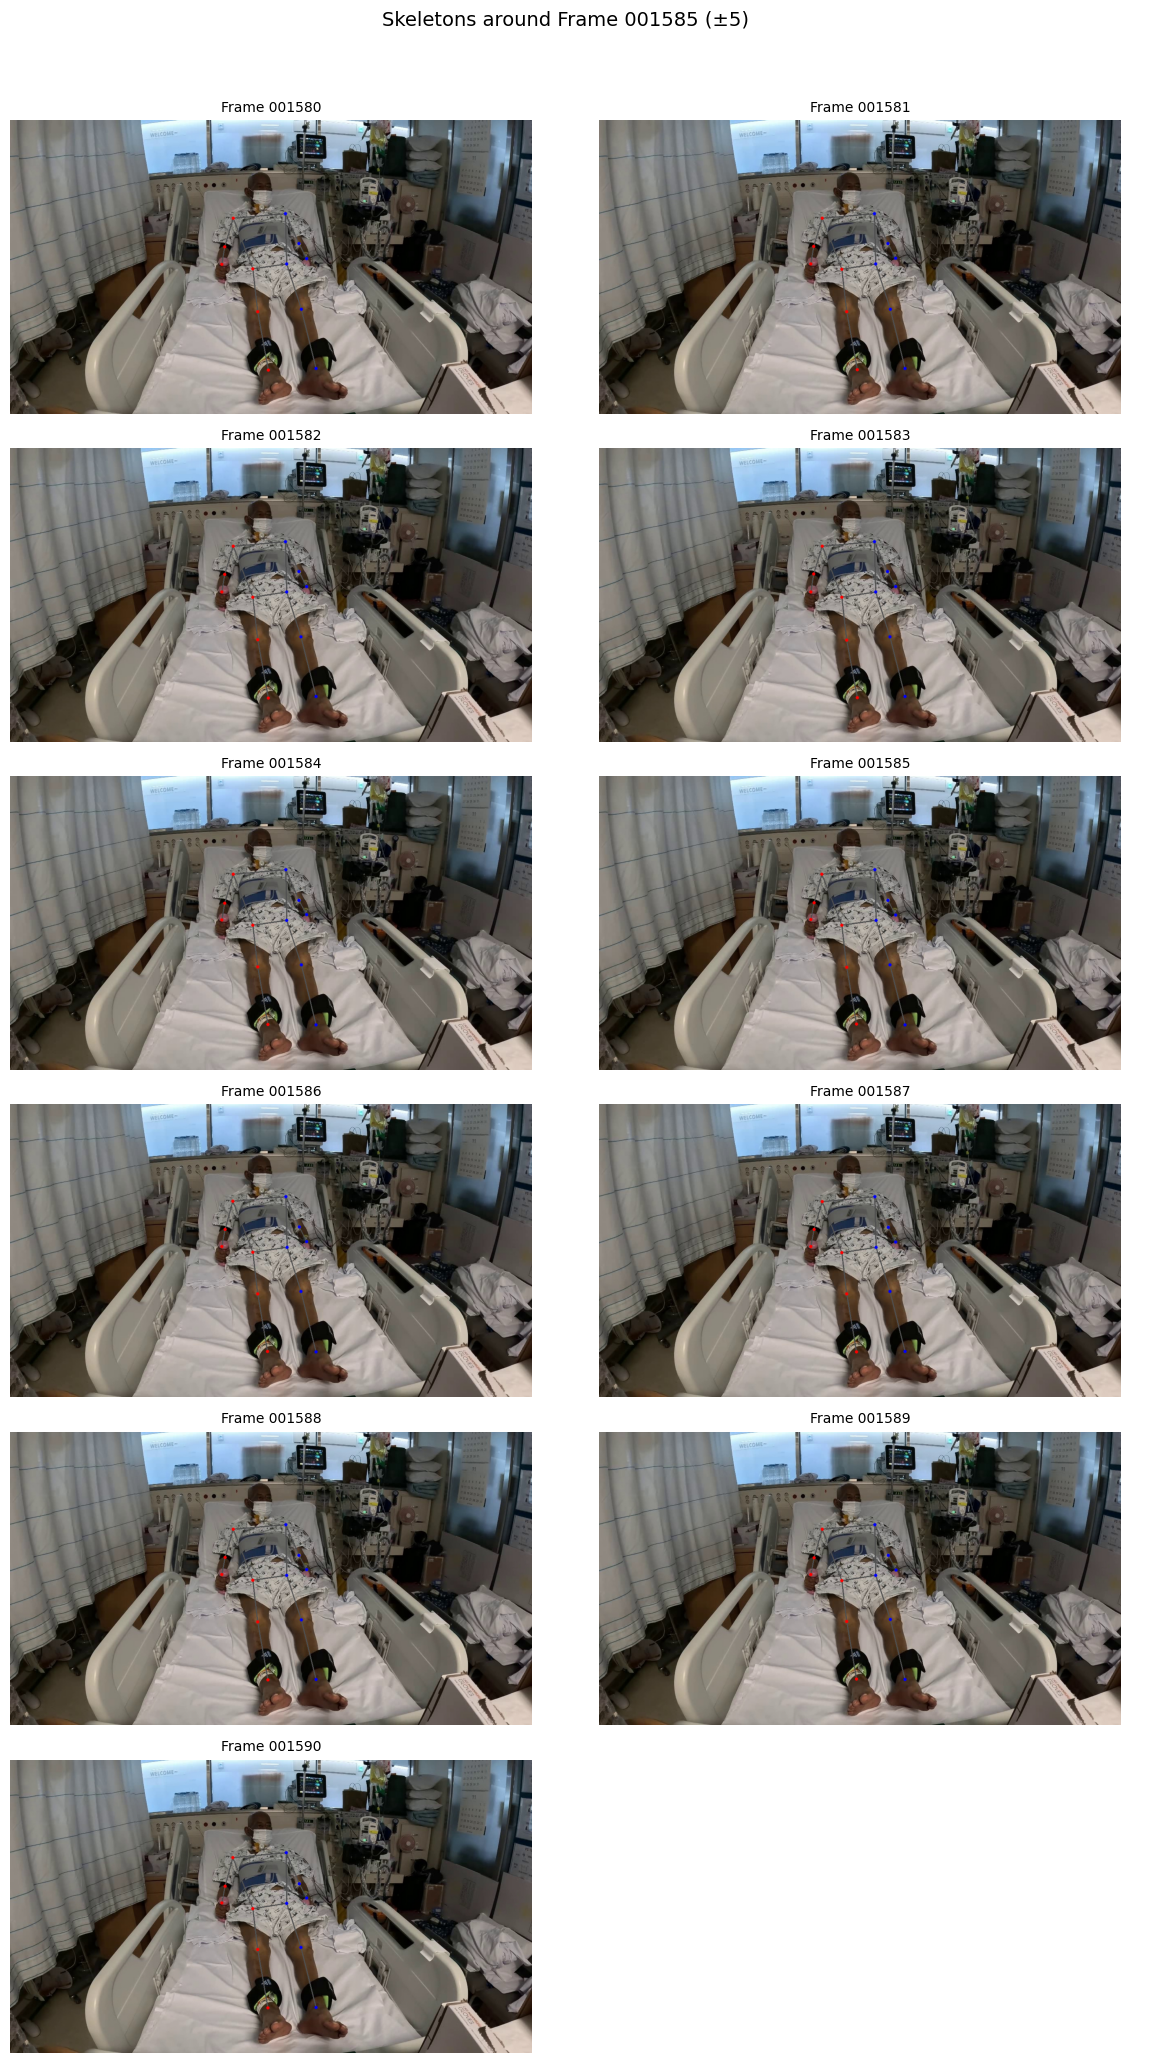

In [36]:
# 기준 프레임 100 → 앞뒤 5프레임씩 (총 11장)
visualize_frame_overlay(
    frame_dir=FRAME_DIR,
    json_dir=INTERP_DIR,
    frame_idx=1585,
    window=5
)


## IQR 시각화

[INFO] 총 45614개 JSON 로드 중...


100% 45614/45614 [00:34<00:00, 1310.60it/s]


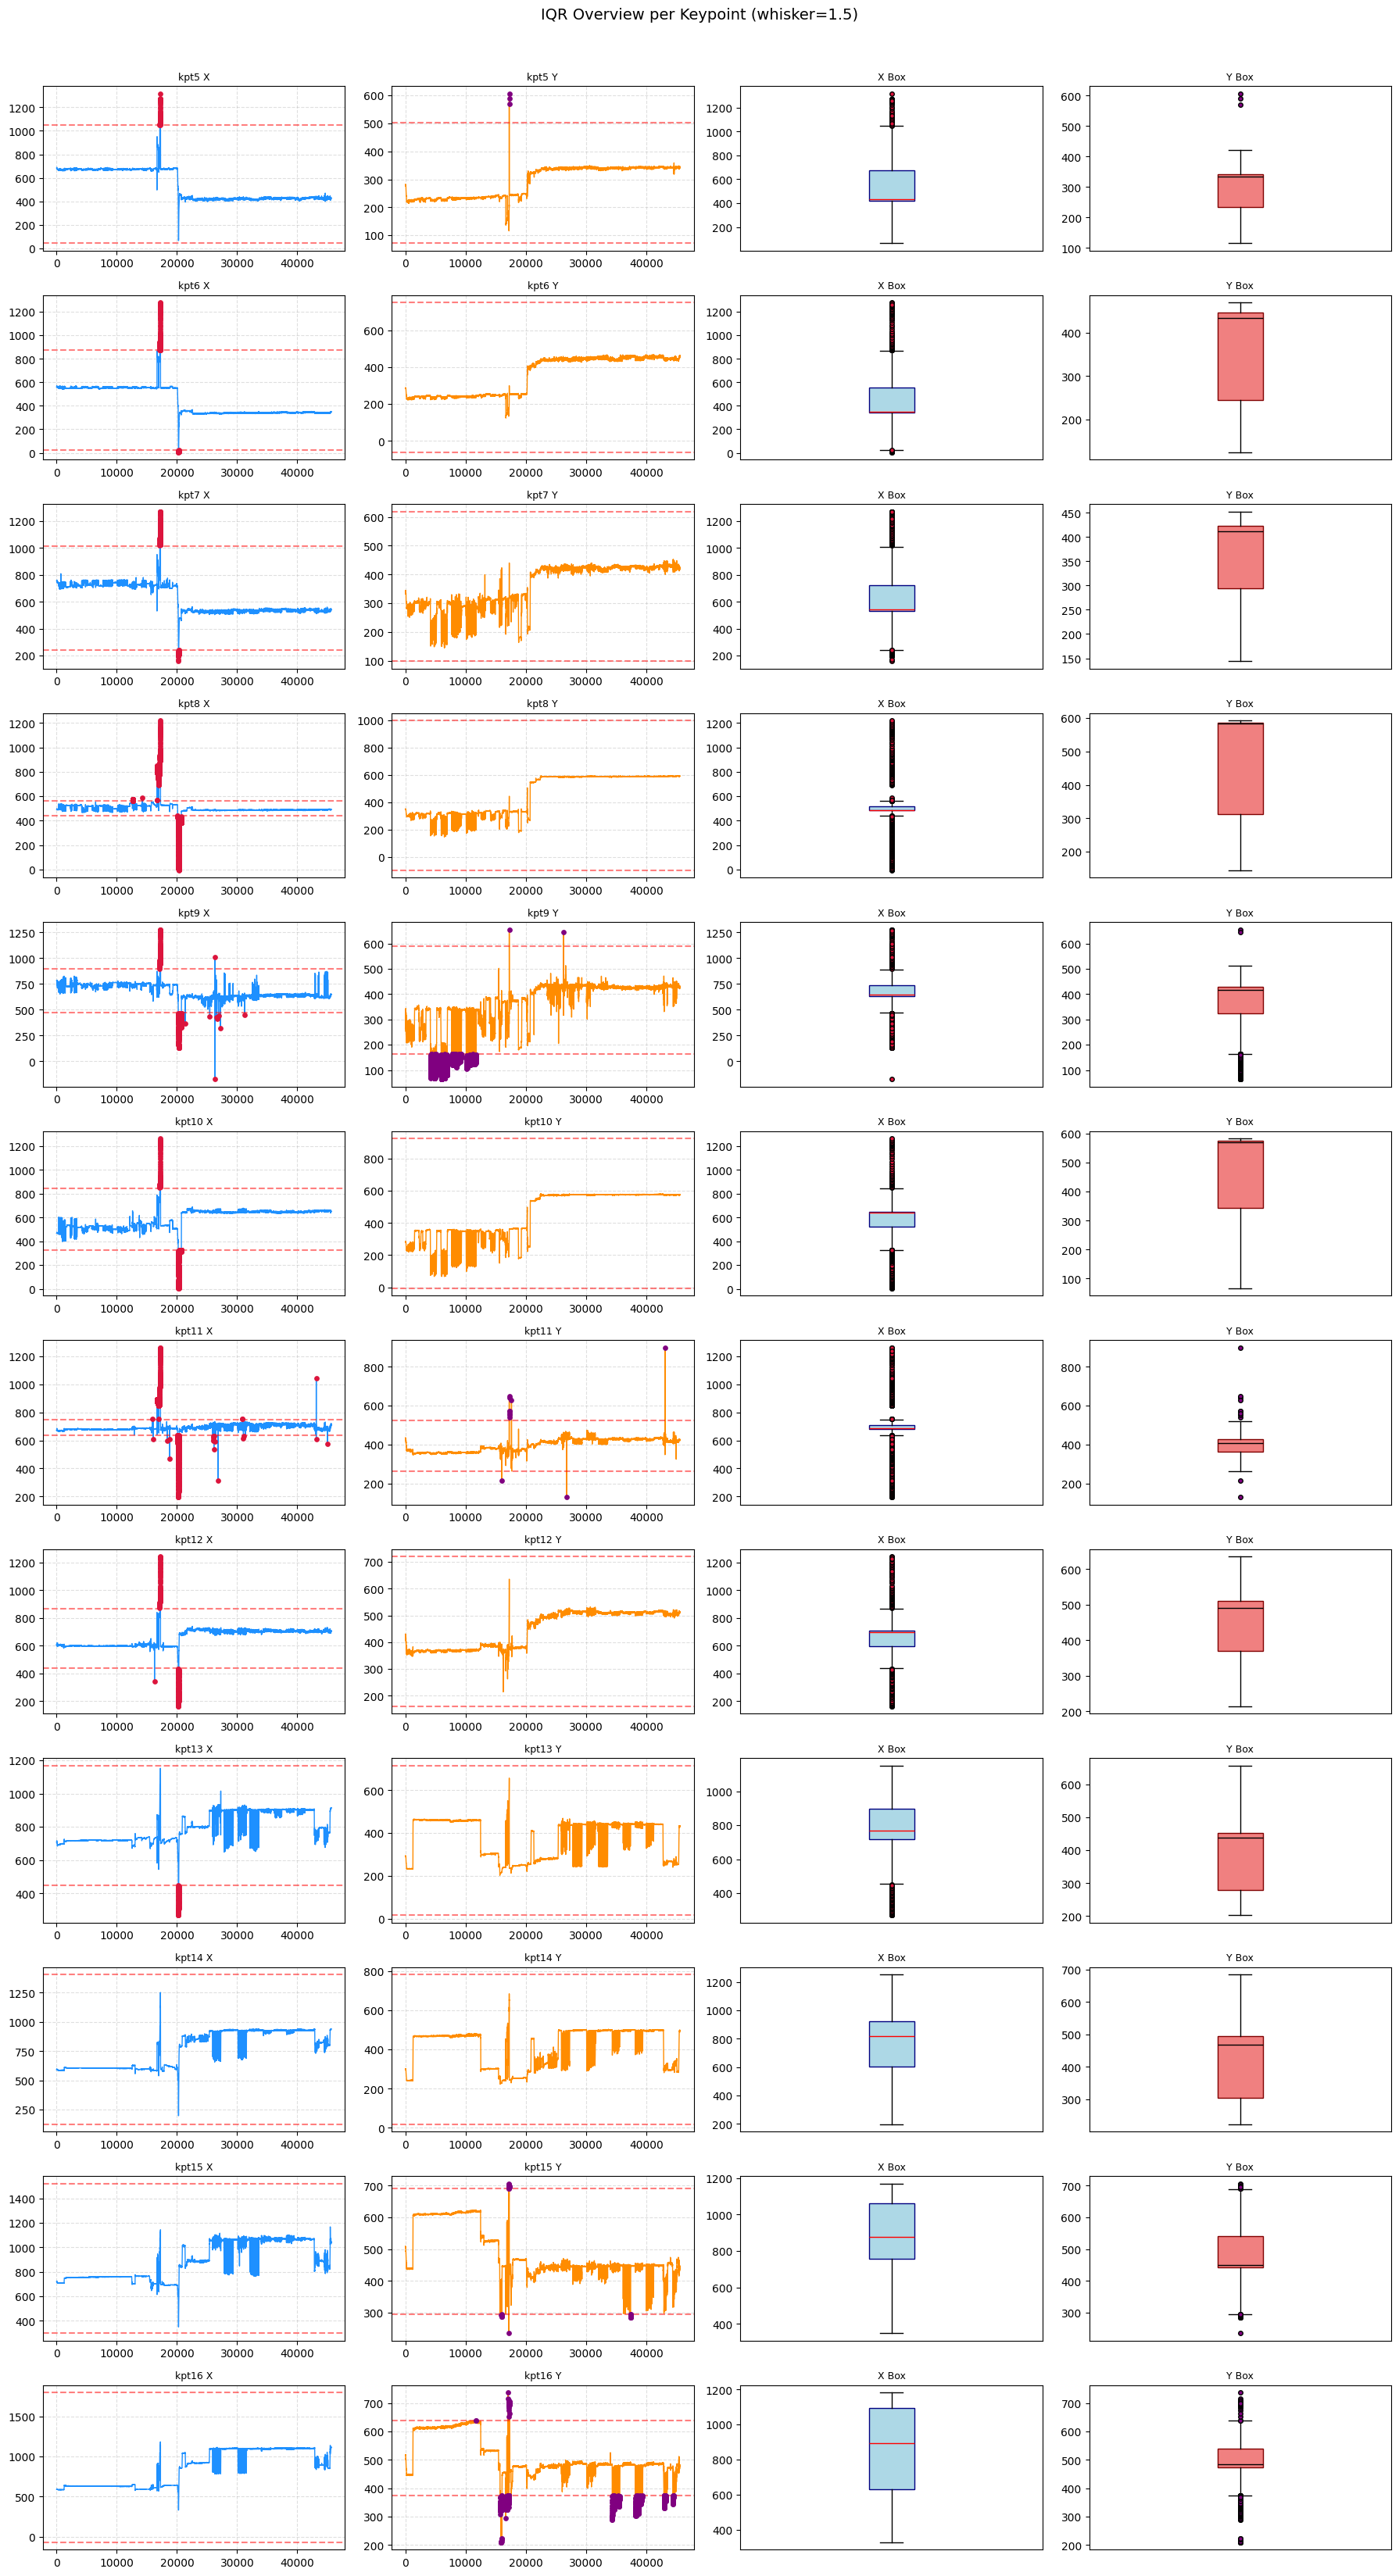

In [28]:
plot_keypoint_iqr_overview(INTERP_DIR, keypoint_range=(5, 17), whisker=1.5)

## velocity outlier 시각화

[INFO] 총 45614개 JSON 로드 중...


Loading JSON: 100% 45614/45614 [00:35<00:00, 1278.30it/s]



[INFO] Keypoint 5
  X outliers (82): [1152, 1298, 1319, 2436, 2948, 3198, 3312, 16681, 16682, 16687, 16688, 16950, 16986, 17144, 17185, 17186, 17230, 17231, 17232, 17233, 17234, 17235, 17236, 17237, 17238, 17239, 17240, 17241, 17252, 17253, 17255, 17258, 17259, 17261, 17262, 17263, 20159, 20735, 20736, 20737, 20739, 21400, 21401, 23172, 25344, 38352, 42898, 43068, 43324, 43474, 43577, 43580, 44004, 44028, 44079, 44510, 44548, 44552, 44558, 44565, 44600, 44606, 44611, 44614, 44618, 44623, 44628, 44631, 44633, 44634, 44635, 44636, 44638, 44642, 44646, 44648, 44668, 45010, 45025, 45082, 45359, 45424]
  Y outliers (77): [579, 16681, 16682, 16687, 16688, 16950, 16986, 17252, 17253, 17254, 17255, 17258, 17261, 17262, 17263, 18804, 20256, 20263, 20264, 20266, 20291, 20292, 20293, 20294, 20301, 20319, 20320, 20336, 20337, 20338, 20376, 20382, 20388, 20393, 20394, 20421, 20447, 20503, 20652, 20659, 20680, 20681, 20688, 20689, 20698, 20700, 20712, 20717, 20718, 20724, 20736, 21400, 21401, 23402

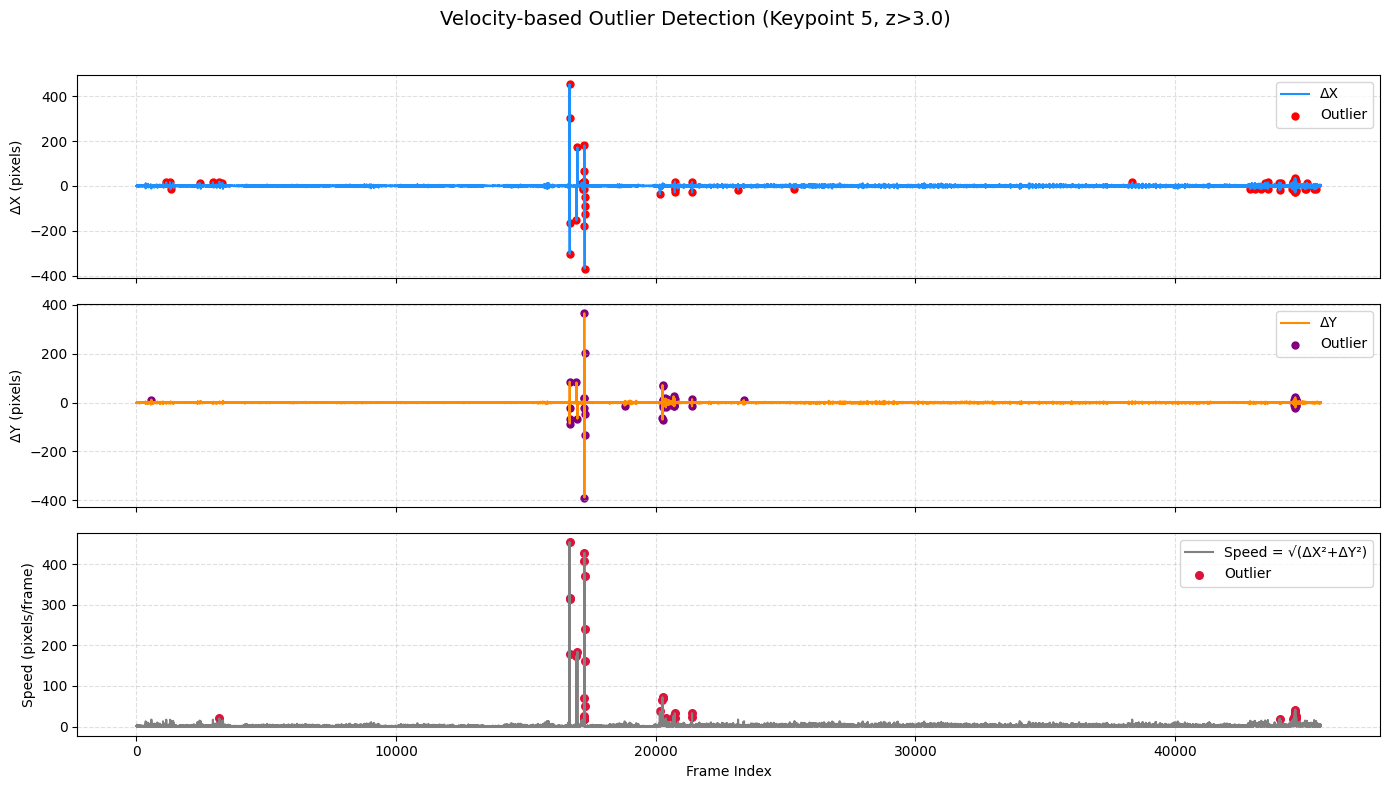

In [33]:
plot_velocity_outliers(
    json_dir=INTERP_DIR,
    target_kps=[5],
    z_thresh=3.0   # z-score 임계값 (2.5~3.0 추천)
)


# 보간 및 변경

## 대상(환자) 추출

In [27]:
overwrite_json_with_tracked_patient(INTERP_DIR)


총 45614 프레임에서 환자 skeleton 추적 시작


Patient Skeleton Tracking: 100% 45614/45614 [02:01<00:00, 376.30frame/s]



✅ 추적 완료: 45614 프레임
   • Ghost 유지 프레임: 8

총 45614개 JSON 덮어쓰기 시작


Overwrite JSON: 100% 45614/45614 [03:10<00:00, 240.07file/s]

✅ 덮어쓰기 완료 → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/4_INTERP_DATA/Won_Kim_research_at_Bosanjin/M01_VISIT12


## 결측치 보간

In [76]:
interpolate_missing_keypoints(
    json_dir=INTERP_DIR,  # 결측치가 존재하는 폴더
    save_dir=None          # None → 원본 덮어쓰기
)


[INFO] 총 345개 JSON에서 결측치 탐색 및 보간 중...
✅ 결측치 없음. 보간 불필요.


## 특정 frame 선형 보간

In [16]:
manual_linear_interpolate_frames(
    json_dir=INTERP_DIR,
    target_frames= [24, 25, 26, 27, 33, 111, 112, 113, 114, 115, 116, 117, 118, 119, 298, 299, 302, 303],   # 연속 & 비연속 혼합
    target_kps=[5,6,7,8,9,10,11,12,13,14,15,16]
)


[INFO] 총 18개 target frame → 연속 구간 단위 보간 시작
✅ Frames 24~27: 연속 구간 보간 완료 ([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])


IndexError: list index out of range

## keypoints 고정


In [68]:
# 예: 315 프레임의 8번, 10번 keypoints를 전체 프레임에 고정
fix_keypoints_across_frames(
    json_dir=INTERP_DIR,
    ref_frame=130,
    target_kps=[8,10]
)


[INFO] 기준 프레임 130의 [8, 10]번 keypoints 좌표 고정값 → {8: array([699.47084697, 424.92653417]), 10: array([665.14799695, 439.3601979 ])}


Fixing keypoints: 100% 343/343 [00:07<00:00, 46.93it/s]

✅ [8, 10]번 keypoints를 프레임 130 기준으로 전체 고정 완료 → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/4_INTERP_DATA/AI_dataset/N02/N02_Ward/diagonal__clamshell_supine


## IQR Outlier 보간

In [90]:
interpolate_outliers(
    json_dir=INTERP_DIR,
    target_kps=[8, 10],
    whisker=1.5,
    axis='both' #x,y,both
)


[INFO] 총 337개 JSON 로드 중...
[INFO] kpt8: 29개 Outlier → both-축 기준 연속 구간 보간 중...
    → 보간 완료 구간: [(51, 53), (84, 86), (101, 102), (104, 106), (122, 122), (125, 127), (135, 139), (173, 173), (176, 177), (209, 209), (212, 212), (220, 220), (222, 224)]
[INFO] kpt10: 24개 Outlier → both-축 기준 연속 구간 보간 중...
    → 보간 완료 구간: [(44, 44), (91, 98), (180, 185), (258, 266)]


Saving interpolated JSON: 100% 337/337 [00:04<00:00, 77.26it/s] 

✅ Outlier 보간 완료 (both-축, keypoints=[8, 10], whisker=1.5) → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/4_INTERP_DATA/AI_dataset/N02/N02_Ward/diagonal__hip_knee_flexion


## velocity 보간

In [25]:
interpolate_velocity_outliers(
    json_dir=INTERP_DIR,
    target_kps=[9, 11],
    z_thresh=3.0
)


[INFO] 총 662개 JSON 로드 중...
[INFO] kpt9: 13개 Outlier → 연속 구간 단위 보간 중...
    → 보간 구간 36~37 (2프레임) 완료
    → 보간 구간 40~40 (1프레임) 완료
    → 보간 구간 64~64 (1프레임) 완료
    → 보간 구간 113~113 (1프레임) 완료
    → 보간 구간 162~162 (1프레임) 완료
    → 보간 구간 266~266 (1프레임) 완료
    → 보간 구간 318~319 (2프레임) 완료
    → 보간 구간 361~361 (1프레임) 완료
    → 보간 구간 398~399 (2프레임) 완료
    → 보간 구간 419~419 (1프레임) 완료
[INFO] kpt11: 19개 Outlier → 연속 구간 단위 보간 중...
    → 보간 구간 113~113 (1프레임) 완료
    → 보간 구간 126~127 (2프레임) 완료
    → 보간 구간 266~266 (1프레임) 완료
    → 보간 구간 281~281 (1프레임) 완료
    → 보간 구간 283~283 (1프레임) 완료
    → 보간 구간 303~304 (2프레임) 완료
    → 보간 구간 307~309 (3프레임) 완료
    → 보간 구간 311~312 (2프레임) 완료
    → 보간 구간 443~444 (2프레임) 완료
    → 보간 구간 446~447 (2프레임) 완료
    → 보간 구간 451~451 (1프레임) 완료
    → 보간 구간 512~512 (1프레임) 완료


Saving interpolated JSON: 100% 662/662 [00:03<00:00, 177.06it/s]

✅ 연속 outlier 보간 완료 (keypoints=[9, 11], z_thresh=3.0) → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/4_INTERP_DATA/AI_dataset/N02/N02_Treatment/lateral__hip_flexion_extension_chair


## smoothing 적용

In [91]:
smooth_keypoints(
    json_dir=INTERP_DIR,
    target_kps=[5,6,7,8,9,10,11,12,13,14,15,16],  # 어깨~발목 전체
    # target_kps=[11],  # 어깨~발목 전체
    window=10,        # 🔹 노이즈가 적을 땐 작은 윈도우 (3~5)
    method="moving"  # 🔹 단순 이동평균
)


[INFO] 총 337개 JSON 로드 → smoothing keypoints: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


Saving smoothed JSON: 100% 337/337 [00:04<00:00, 67.81it/s] 

✅ Smoothing 완료 → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/4_INTERP_DATA/AI_dataset/N02/N02_Ward/diagonal__hip_knee_flexion


# 영상 생성

In [32]:
import sys
sys.path.append("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/ASAN_01_Repeatition_Counter")

from functions.render_skeleton_video import render_skeleton_video
render_skeleton_video(
    frame_dir=FRAME_DIR,
    json_dir=INTERP_DIR,
    out_mp4=VIDEO_DIR,
    fps=30,
    model_type="coco17",
    
)

M01_VISIT12: 100% 45614/45614 [15:34<00:00, 48.81frame/s]


✅ Skeleton overlay 완료 → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/3_MP4/Won_Kim_research_at_Bosanjin/M01_VISIT12.mp4


# CSV is_train 업데이트

In [93]:
import pandas as pd
from pathlib import Path

# -------------------------------------------------------
# TARGET_ROW의 is_train 값 변경
# -------------------------------------------------------
meta.loc[TARGET_ROW, 'is_train'] = True  # True로 설정
print(f"[INFO] {TARGET_ROW}행의 is_train 값을 True로 변경했습니다.")

# -------------------------------------------------------
# CSV 저장
# -------------------------------------------------------
meta.to_csv(CSV_PATH, index=False)  # 덮어쓰기 저장
print(meta.loc[TARGET_ROW,'video_path'])
print(f"✅ 변경사항을 저장했습니다: {CSV_PATH}")


[INFO] 136행의 is_train 값을 True로 변경했습니다.
/workspace/nas203/ds_RehabilitationMedicineData/data/d02/AI_dataset/N02/N02_Ward/diagonal__hip_knee_flexion.mp4
✅ 변경사항을 저장했습니다: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/ASAN_01_Repeatition_Counter/data/metadata_backup.csv
